## Pointwise Sliced Mutual Information

Sample code to generate saliency map and confidence estimate for VGG-16 architecture and STL10 dataset.

In [1]:
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import namedtuple
from PIL import Image
import time
from scipy import stats
import pickle
import cv2
import keras
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = 'cm'

Using TensorFlow backend.


In [2]:
def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
        
def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images
    
def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [3]:
# path to the directory with the data
DATA_DIR = './data'
# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# path to the binary train file with image data
TRAIN_DATA_PATH = './data/stl10_binary/train_X.bin'
# path to the binary train file with labels
TRAIN_LABEL_PATH = './data/stl10_binary/train_y.bin'
# path to the binary test file with image data
TEST_DATA_PATH = './data/stl10_binary/test_X.bin'
# path to the binary test file with labels
TEST_LABEL_PATH = './data/stl10_binary/test_y.bin'

In [ ]:
download_and_extract()

In [4]:
train_labels = read_labels(TRAIN_LABEL_PATH)
train_images = read_all_images(TRAIN_DATA_PATH)

test_labels = read_labels(TEST_LABEL_PATH)
test_images = read_all_images(TEST_DATA_PATH)

In [5]:
resized_train_images = []
resized_test_images = []
for n in range(len(train_images)):
    img = Image.fromarray(train_images[n])
    img = img.resize((224, 224), Image.BILINEAR) 
    resized_train_images.append(np.array(img))
X_train = np.array(resized_train_images)
for n in range(len(test_images)):
    img = Image.fromarray(test_images[n])
    img = img.resize((224, 224), Image.BILINEAR) 
    resized_test_images.append(np.array(img))
X_test = np.array(resized_test_images)

X_train_proc = keras.applications.vgg16.preprocess_input(X_train)
X_test_proc = keras.applications.vgg16.preprocess_input(X_test)
X_train_proc = X_train_proc / 255.
X_test_proc = X_test_proc / 255.
Y_train = keras.utils.to_categorical(train_labels)
Y_test = keras.utils.to_categorical(test_labels)
Dataset = namedtuple('Dataset',['X','Y','y'])
trn = Dataset(X_train_proc, Y_train, train_labels)
tst = Dataset(X_test_proc , Y_test, test_labels)

In [6]:
input_tensor = keras.layers.Input((224,224,3))
base_model = keras.applications.VGG16(include_top=False,
                                      weights='imagenet',
                                      input_tensor=input_tensor,
                                      input_shape=(trn.X.shape[1:]))
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
output = keras.layers.Dense(4096, activation='relu')(output)
output = keras.layers.Dense(trn.Y.shape[1], activation='linear')(output)

model = keras.models.Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0, threshold=1):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best_trn_acc = 0
    
    def on_epoch_end(self, epoch, logs=None):
        trn_acc = self.model.evaluate(trn.X, trn.Y, batch_size=256, verbose=0)[1]       
        print('Training Accuracy: %0.03f'%trn_acc)
        if np.greater(np.round(trn_acc,3), np.round(self.best_trn_acc,3)):
            print('Set best train accuracy to: %0.03f'%trn_acc)
            self.best_trn_acc = trn_acc
            self.wait = 0
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

custom_ES = CustomEarlyStopping(patience=5)
lr_decay = ReduceLROnPlateau(monitor='accuracy', factor=0.9, patience=10, verbose=1)

r = model.fit(x=trn.X, y=trn.Y, 
              verbose    = 1, 
              batch_size = 32,
              epochs = 350,
              callbacks = [custom_ES, lr_decay])

In [7]:
model = keras.models.load_model("trained_vgg16_stl10")

In [8]:
def sample_from_sphere(d):
    vec = np.random.randn(d, 1)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [9]:
sorted_trn_X = []
sorted_trn_Y = []
sorted_trn_y = []
for k in range(1,11):
    for n in range(trn.X.shape[0]):
        if trn.y[n] == k:
            sorted_trn_X.append(trn.X[n])
            sorted_trn_Y.append(trn.Y[n])
            sorted_trn_y.append(trn.y[n])
sorted_trn_X = np.array(sorted_trn_X)
sorted_trn_Y = np.array(sorted_trn_Y)
sorted_trn_y = np.array(sorted_trn_y)

### a. Fiber-wise PSI

Run:0
Fiber 0: PSI-mean=-0.118, PSI-max=0.361 (time taken: 0.884)
Fiber 1: PSI-mean=-0.156, PSI-max=0.521 (time taken: 0.932)
Fiber 2: PSI-mean=-0.189, PSI-max=0.464 (time taken: 0.909)
Fiber 3: PSI-mean=-0.234, PSI-max=0.612 (time taken: 0.914)
Fiber 4: PSI-mean=-0.178, PSI-max=0.789 (time taken: 0.914)
Fiber 5: PSI-mean=-0.225, PSI-max=0.842 (time taken: 0.925)
Fiber 6: PSI-mean=-0.265, PSI-max=1.006 (time taken: 0.907)
Fiber 7: PSI-mean=-0.257, PSI-max=0.513 (time taken: 0.914)
Fiber 8: PSI-mean=-0.345, PSI-max=0.716 (time taken: 0.902)
Fiber 9: PSI-mean=-0.263, PSI-max=0.691 (time taken: 0.918)
Fiber 10: PSI-mean=-0.255, PSI-max=0.517 (time taken: 0.909)
Fiber 11: PSI-mean=-0.097, PSI-max=1.059 (time taken: 0.902)
Fiber 12: PSI-mean=-0.136, PSI-max=1.090 (time taken: 0.928)
Fiber 13: PSI-mean=-0.176, PSI-max=0.608 (time taken: 0.919)
Fiber 14: PSI-mean=-0.130, PSI-max=0.928 (time taken: 0.907)
Fiber 15: PSI-mean=-0.275, PSI-max=0.557 (time taken: 0.928)
Fiber 16: PSI-mean=-0.433, P

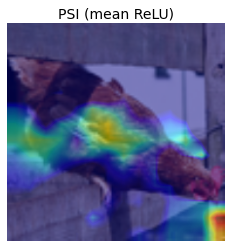

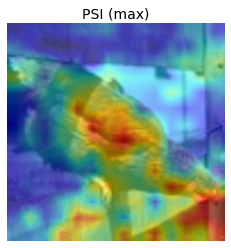

In [40]:
# Index of test example
n = 6
# Number of runs
n_runs = 1
psi_mean_all_run = []
psi_max_all_run = []
for run in range(n_runs):
    print(f'Run:{run}')
    int_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('block5_conv3').output)
    activity = int_model.predict(sorted_trn_X, batch_size=32)
    if len(activity.shape) > 2:
        activity = activity.reshape(activity.shape[0],activity.shape[2]*activity.shape[2],activity.shape[3])
    activity_sample = int_model.predict(np.expand_dims(tst.X[n], axis=0), batch_size=32)
    if len(activity_sample.shape) > 2:
        activity_sample = activity_sample.reshape(activity_sample.shape[0],activity_sample.shape[1]*activity_sample.shape[2],activity_sample.shape[3])
    predictions = model.predict(np.expand_dims(tst.X[n], axis=0))
    pred_cls = np.argmax(predictions)
    psi_mean_fiber = []
    psi_max_fiber = []
    for fiber in range(activity.shape[1]):
        start_time = time.time()
        psi_list = []
        # no. of projections
        for m in range(100):
            theta = sample_from_sphere(activity.shape[2])
            thetaX = np.dot(activity[:,fiber,:],theta)
            mu_list = []
            std_list = []
            p_thetax_given_y = []
            for k in range(10):
                thetaX_class = thetaX[500*k:500*(k+1)]
                mu, std = stats.norm.fit(thetaX_class)
                mu_list.append(mu)
                std_list.append(std)
                p_thetax_given_y.append(stats.norm.pdf(np.dot(activity_sample[:,fiber,:], theta), mu, std))
#             psi = np.log2(p_thetax_given_y[pred_cls-1]/(0.1*np.sum(p_thetax_given_y)))
            psi = np.log2(p_thetax_given_y[1]/(0.1*np.sum(p_thetax_given_y)))
            psi_list.append(psi)
        end_time = time.time()
        elapsed_time = end_time - start_time
        psi_mean_fiber.append(np.mean(psi_list))
        psi_max_fiber.append(np.max(psi_list))
        print(f'Fiber {fiber}: PSI-mean={psi_mean_fiber[-1]:.3f}, PSI-max={psi_max_fiber[-1]:.3f} (time taken: {elapsed_time:.3f})')
    psi_mean_all_run.append(psi_mean_fiber)
    psi_max_all_run.append(psi_max_fiber)
    
psi_mean_all_run = np.array(psi_mean_all_run)
psi_mean = np.mean(psi_mean_all_run, axis=0).reshape((14,14))
psi_max_all_run = np.array(psi_max_all_run)
psi_max = np.mean(psi_max_all_run, axis=0).reshape((14,14))

img_mean = Image.fromarray(psi_mean)
img_mean = img_mean.resize((224, 224), Image.BILINEAR) 
psi_mean_img = np.array(img_mean)
img_max = Image.fromarray(psi_max)
img_max = img_max.resize((224, 224), Image.BILINEAR) 
psi_max_img = np.array(img_max)

# mean ReLU visualization
plt.imshow(X_test[n])
plt.imshow(psi_mean_img.clip(min=0), cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('PSI (mean ReLU)', fontsize=14)

plt.show()

# max visualization
plt.imshow(X_test[n])
plt.imshow(psi_max_img, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('PSI (max)', fontsize=14)

plt.show()

In [20]:
def grad_cam(input_model, image, cls, layer_name): 
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (224,224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

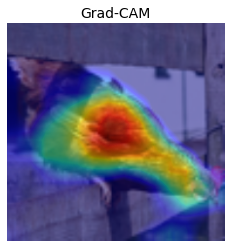

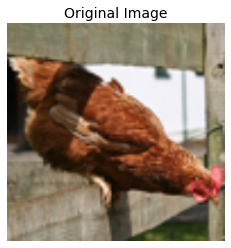

In [39]:
n=6
predictions = model.predict(np.expand_dims(tst.X[n], axis=0))
cls = np.argmax(predictions)
# gradcam = grad_cam(model, np.expand_dims(tst.X[n], axis=0), cls, 'block5_conv3')
gradcam = grad_cam(model, np.expand_dims(tst.X[n], axis=0), 2, 'block5_conv3')

plt.imshow(X_test[n])
plt.imshow(gradcam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Grad-CAM', fontsize=14)

plt.show()

plt.imshow(X_test[n])
plt.title('Original Image', fontsize=14)
plt.axis('off')

plt.show()

In [36]:
print('True:',tst.y[n])
print('Predicted:',cls)

True: 2
Predicted: 6


### b. Sample-wise PSI

In [ ]:
# Index of test example
n = 123
# Number of runs
n_runs = 1
psi_all_run = []
for run in range(n_runs):
    print(f'Run:{run}')
    int_model = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    activity = int_model.predict(sorted_trn_X, batch_size=32)
    start_time = time.time()
    activity_sample = int_model.predict(np.expand_dims(tst.X[n], axis=0), batch_size=32)
    predictions = model.predict(np.expand_dims(tst.X[n], axis=0))
    pred_cls = np.argmax(predictions)
    psi_list = []
    for m in range(250):
        theta = sample_from_sphere(activity.shape[1])
        thetaX = np.dot(activity,theta)
        mu_list = []
        std_list = []
        p_thetax_given_y = []
        for k in range(10):
            thetaX_class = thetaX[500*k:500*(k+1)]
            mu, std = stats.norm.fit(thetaX_class)
            mu_list.append(mu)
            std_list.append(std)
            p_thetax_given_y.append(stats.norm.pdf(np.dot(activity_sample, theta), mu, std))
        psi = np.log2(p_thetax_given_y[pred_cls-1]/(0.1*np.sum(p_thetax_given_y)))
        psi_list.append(psi)
    end_time = time.time()
    elapsed_time = end_time - start_time
    psi_all_run.append(np.mean(psi_list))
        print(f'Image {i+1}: PSI={psi_all_run[-1]:.3f} (time taken: {elapsed_time:.3f})')
        
mean_psi = np.mean(psi_all_run)
print('Confidence estimate:',mean_psi)